In [1]:
# imports of necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define some key functions 

In [2]:
def statebreaker(city_state):
    """
    Params:  
    city_state - A string consisting of a city name and a state abbreviation
    
    Function:  
    Splits the string, extracting the state abbreviation.
    """
    split_list = city_state.split(',')
    return split_list[-1]


def delay_binarizer(input_col):
    
    """
    Params:
    input_col - an input of time in minutes
    
    Function:
    Returns 0 if the time is positive (delayed) or 1 if the flight is early/on time"""
    if input_col > 0:
        return 0
    else:
        return 1

    
def get_hour(time):
    
    """
    Params - A time in format HHMM.0
    
    Returns  the two digits representing the hour of the flight
    """
    
    s = str(int(time))
    if len(s) <= 2:
        return 0
    else:
        return int(s[:-2])




In [3]:

def get_min(time):
    
    """
    Params - A time in format HHMM.0
    
    Returns  the two digits representing the minutes of the flight
    """
    s = str(int(time))
    if len(s) <=2:
        return(int(s))
    else:
        return (int(s[-2:]))

def haul_type(elapsed_time):
    
    """
    Params - Duration of a flight
    
    Returns -  A haul type as defined below:
    
        Short - Less than 180 minutes
        Medium - Between 180 and 360 minutes
        Long - Over 360 minutes
     """
    if elapsed_time < 180:
        return 'Short'
    elif 180 < elapsed_time < 360:
        return 'Medium'
    else:
        return 'Long'

## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.

* Check the cumulative delay minutes per tail number.  Do some planes have a higher tendency to be late due to mechanical issues.  --- YES!!!!
* Do certain carriers have a higher likelihood of delays than others? Do certain airports? Flight numbers?
* What time of day do most delays occur?
* Weather, weather, weather

## Columns to Drop

* Flights - There is only one value in thw whole table
* All 5 features with the _delay tag
* OP_carrier_fl_num, op_unique_carrier
* Taxi in, Taxi Out
* branded_code_share
* origin_airport_id, dest_airport_id
* Wheels_off, wheels_on
* Cancelled, cancellation code
* Diverted

## Feature Addition

* Split fl_date into day, month, year
* Created columns for departure state and destination state
* Created a column called flight_time_change representing the change in actual vs expected flight time
* Split the crs_dep_time column into dep_hour and dep_minute for analysis
* Created a haul_type column where flight times are classified as long, short or medium haul
* Plane, airline and airport on-time percentages



In [4]:
data = pd.read_csv('data/flights.csv', low_memory=False)

In [5]:
# Let's get a sense of the data
data.head()

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
0,0,2019-01-01,AA,AA_CODESHARE,AA,5606,OH,N575NN,5606,13577,...,157.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,10529,...,313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-01-01,AA,AA_CODESHARE,AA,5607,OH,N254PS,5607,11278,...,313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-01-01,AA,AA_CODESHARE,AA,5608,OH,N710PS,5608,11278,...,396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-01-01,AA,AA_CODESHARE,AA,5610,OH,N515AE,5610,13931,...,290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.describe()

,Unnamed: 0,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
count,1.328673e+06,1.328673e+06,1.328673e+06,1.328673e+06,1.328673e+06,1.328673e+06,1.317997e+06,1.317705e+06,1.317654e+06,1.317661e+06,...,1.328673e+06,267798.000000,267798.000000,267798.000000,267798.000000,267798.000000,8492.000000,8491.000000,8492.000000,0.0
mean,6.643360e+05,2.805572e+03,2.805457e+03,1.269756e+04,1.269756e+04,1.328600e+03,1.336242e+03,1.159969e+01,1.783836e+01,1.360795e+03,...,7.839314e+02,21.063357,3.442923,13.534997,0.113455,27.466124,1275.213377,35.267106,34.692181,NaN
std,3.835550e+05,1.888275e+03,1.888340e+03,1.521961e+03,1.521962e+03,4.896264e+02,5.017760e+02,4.893111e+01,1.024663e+01,5.024221e+02,...,5.913717e+02,64.371996,32.583072,31.265017,3.271435,54.148878,515.078082,29.328536,28.013972,NaN
min,0.000000e+00,1.000000e+00,1.000000e+00,1.013500e+04,1.013500e+04,1.000000e+00,1.000000e+00,-6.110000e+02,0.000000e+00,1.000000e+00,...,3.100000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,NaN
25%,3.321680e+05,1.157000e+03,1.157000e+03,1.129200e+04,1.129200e+04,9.170000e+02,9.220000e+02,-5.000000e+00,1.100000e+01,9.380000e+02,...,3.490000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,817.000000,16.000000,16.000000,NaN
50%,6.643360e+05,2.401000e+03,2.401000e+03,1.288900e+04,1.288900e+04,1.321000e+03,1.330000e+03,-2.000000e+00,1.500000e+01,1.344000e+03,...,6.230000e+02,2.000000,0.000000,2.000000,0.000000,5.000000,1231.000000,27.000000,27.000000,NaN
75%,9.965040e+05,4.462000e+03,4.462000e+03,1.405700e+04,1.405700e+04,1.733000e+03,1.742000e+03,9.000000e+00,2.100000e+01,1.757000e+03,...,1.023000e+03,18.000000,0.000000,18.000000,0.000000,33.000000,1722.000000,44.000000,44.000000,NaN
max,1.328672e+06,9.401000e+03,9.401000e+03,1.686900e+04,1.686900e+04,2.359000e+03,2.400000e+03,2.007000e+03,1.394000e+03,2.400000e+03,...,5.095000e+03,2007.000000,1847.000000,1447.000000,816.000000,1648.000000,2400.000000,297.000000,247.000000,NaN


# Light Feature Engineering
### These features are designed to facilitate date analysis

Going to need to split the date into day, month, year for some of the analysis.  Might as well get it done now!

In [7]:
# Break fl_date up into it's component day, month, year components
# Also going to drop the Unnamed: 0 column at the same time

data['year'] = pd.DatetimeIndex(data['fl_date']).year
data['month'] = pd.DatetimeIndex(data['fl_date']).month
data['day'] = pd.DatetimeIndex(data['fl_date']).day
data = data.drop(columns = ['fl_date', 
                            'Unnamed: 0',
                            'op_carrier_fl_num',
                            'op_unique_carrier',
                           'carrier_delay',
                           'weather_delay',
                           'nas_delay',
                           'security_delay',
                           'late_aircraft_delay',
                           'dup'])

In [8]:
# Let's break up dep_time into it's component hours and minutes

data['crs_dep_hour'] = data['crs_dep_time'].apply(get_hour)
data['crs_dep_minutes'] = data['crs_dep_time'].apply(get_min)

In [9]:
# Let's separate the state from the city name using statebreaker.

data['dep_state'] = data['origin_city_name'].apply(statebreaker)
data['dest_state'] = data['dest_city_name'].apply(statebreaker)

In [10]:
# Let's make a new feature representing the delta between the expected flight time and the actual flight time
data['flight_time_change'] = data['crs_elapsed_time'] - data['actual_elapsed_time']

# Add another binary feature based on flight_time_change stating whether or not the flight made up ground in the air
data['made_up_time'] = data['flight_time_change'].apply(delay_binarizer)

# Create a binary column for delay

data['on_time'] = data['arr_delay'].apply(delay_binarizer)

In [11]:
# Make a feature name for the type of haul
# Make a feature for each type of haul
data['haul_type'] = data['crs_elapsed_time'].apply(haul_type)



In [12]:
data.columns

Index(['mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'tail_num', 'origin_airport_id', 'origin',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'crs_dep_time', 'dep_time', 'dep_delay', 'taxi_out', 'wheels_off',
       'wheels_on', 'taxi_in', 'crs_arr_time', 'arr_time', 'arr_delay',
       'cancelled', 'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'no_name',
       'year', 'month', 'day', 'crs_dep_hour', 'crs_dep_minutes', 'dep_state',
       'dest_state', 'flight_time_change', 'made_up_time', 'on_time',
       'haul_type'],
      dtype='object')

<AxesSubplot:>

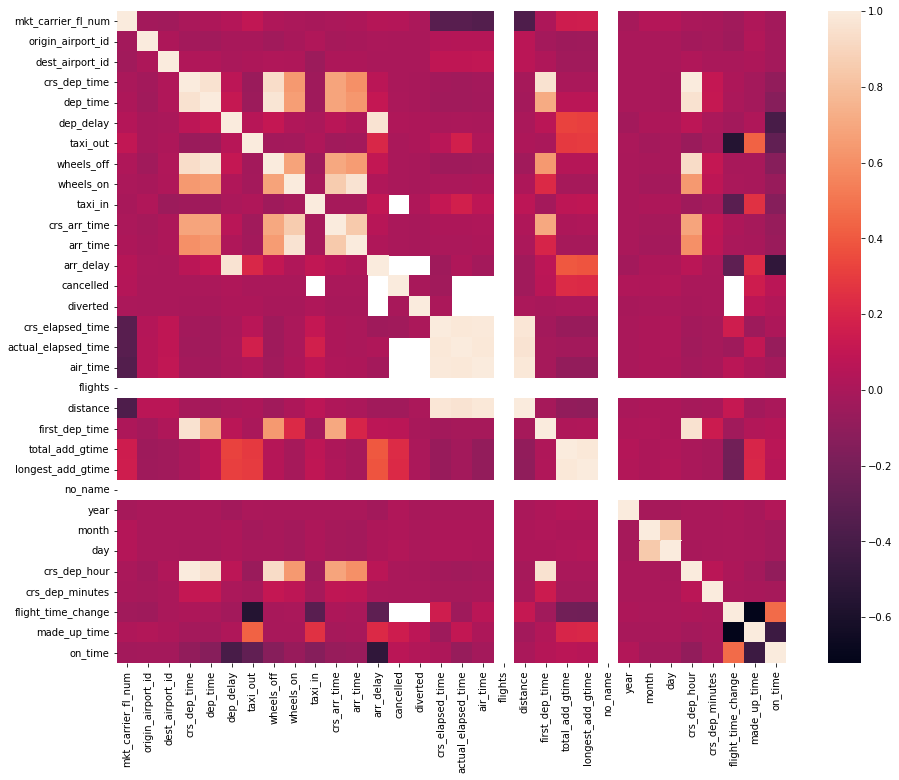

In [13]:
data_corr = data.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data_corr, annot = False)



In [14]:
data['arr_delay'].median()

-6.0

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

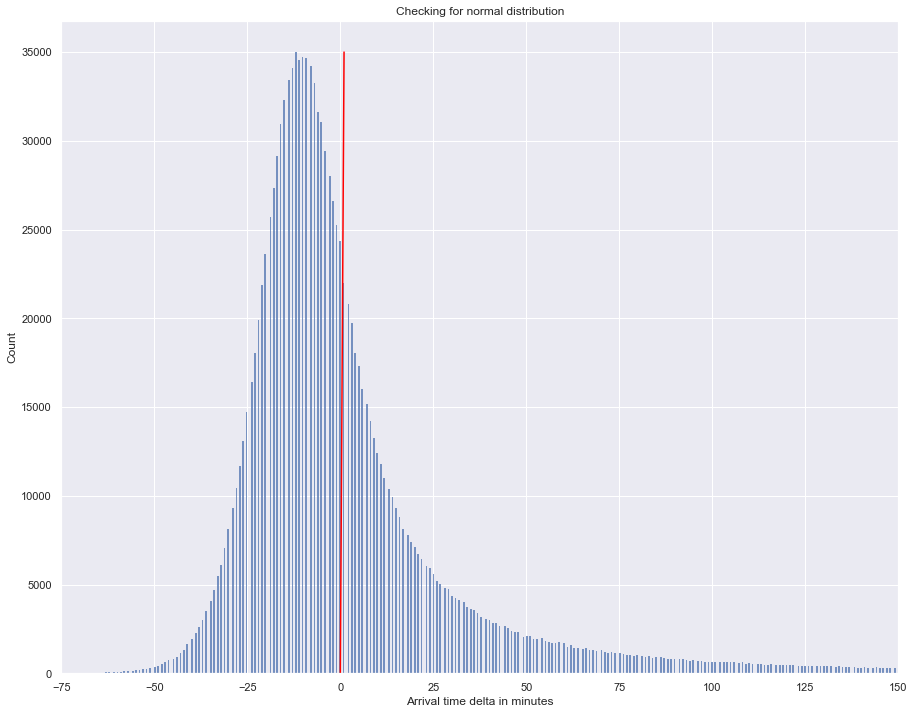

In [15]:
# Check the distribution of the data

sns.set(style = 'darkgrid')
fig, ax = plt.subplots(figsize=(15, 12))

h = sns.histplot(data, x = data['arr_delay'])
h.set(xlim = (-75, 150))
plt.plot([0, 35000], color='red')
plt.xlabel('Arrival time delta in minutes')
plt.title('Checking for normal distribution')
plt.show()

In [16]:
print('Mean flight arrival delta: ', data['arr_delay'].mean(), 'minutes')
print('Median flight arrival delta: ', data['arr_delay'].median(), 'minutes')

Mean flight arrival delta:  5.3905305497555895 minutes
Median flight arrival delta:  -6.0 minutes


#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [17]:
data[['month', 'arr_delay']].groupby('month').mean()

,arr_delay
month,
1,4.726649
12,5.939261


Delays definitely seem to be greater in December than in January, by about 1.2 minutes on average.  Not really concerned with the other months at this point for the purposes of our analysis.

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

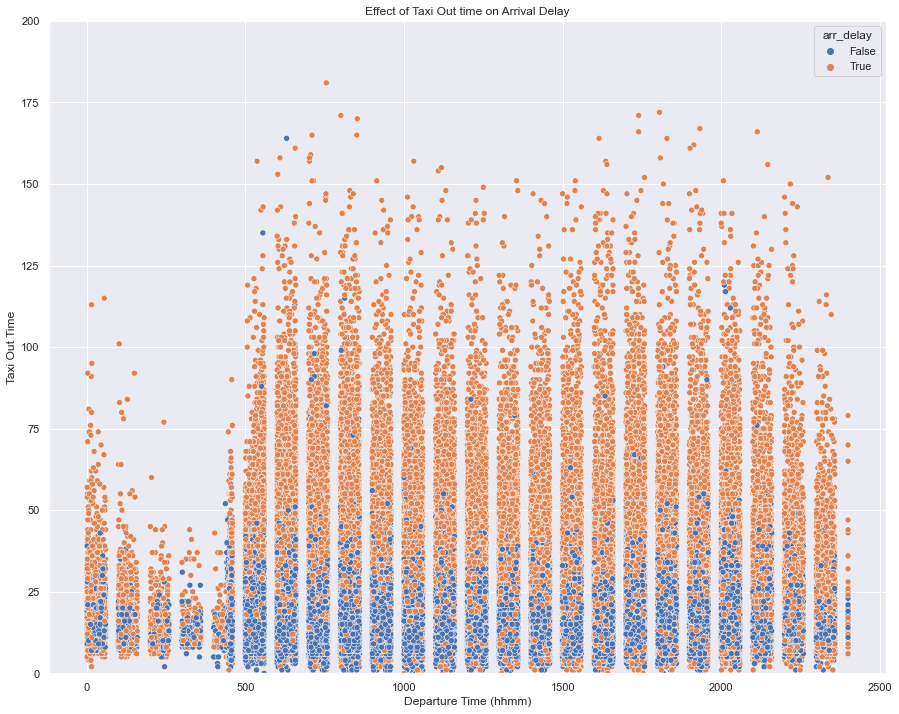

In [18]:
# Make a combined plot where the histogram shows the concentration of flights at a given time and a scatter plot (bubble) shows the duration of the taxi time.


fig, ax = plt.subplots(figsize=(15, 12))
# ax2 = ax.twinx()

# h = sns.histplot(data = data, x = data['dep_time'], ax = ax)
s = sns.scatterplot(data = data, x = data['dep_time'], y = data['taxi_out'], ax = ax, hue = (data['arr_delay'] > 0))


s.set(ylim = (0, 200))
plt.title('Effect of Taxi Out time on Arrival Delay')
plt.xlabel('Departure Time (hhmm)')
plt.ylabel('Taxi Out Time')

plt.show()

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
# ax2 = ax.twinx()

# h = sns.histplot(data = data, x = data['dep_time'], ax = ax)
s = sns.scatterplot(data = data, x = data['dep_time'], y = data['dep_delay'], ax = ax, hue = (data['arr_delay']))

#### **Task 6**: How many states cover 50% of US air traffic? 

In [ ]:
counts = data['dep_state'].value_counts() + data['dest_state'].value_counts()

In [ ]:
counts.index[0]

In [ ]:
big_state_count = 0
high_traffic_states = []
i = 0
while big_state_count <= counts.sum()/2:
    big_state_count += counts[i]
    high_traffic_states.append(counts.index[i])
    i += 1
print("50% of American air traffic occurs in these states: \n", high_traffic_states)

In [ ]:
plt.bar(x = counts.index[:10], height = counts[:10])

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [ ]:
# Make a histogram showing the flight time change for all flights

sns.set(style = 'darkgrid')
fig, ax = plt.subplots(figsize=(15, 12))

h = sns.histplot(data, x = data['flight_time_change'])
h.set(xlim = (-75, 150))
plt.plot([0, 50000], color='red')
plt.xlabel('Flight time change')
plt.title('Do flights make up time in the air?')
plt.show()
# plt.scatter(data['dep_delay'], data['flight_time_change'])

In [ ]:
# Create the same histogram, but this time only use the flights that departed late

dep_delay = data[data['dep_delay'] > 0]

fig, ax = plt.subplots(figsize=(15, 12))
h = sns.histplot(dep_delay, x = dep_delay['flight_time_change'])
h.set(xlim = (-75, 150))
plt.plot([0, 17500], color='red')
plt.xlabel('Flight time change')
plt.title('Do delayed flights make up time in the air?')
plt.show()


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [ ]:
arrays = [data['crs_dep_hour'], data['haul_type']]
hauls = data['haul_type'].to_list()
index = pd.MultiIndex.from_arrays(arrays, names=('Departure Hour', 'Haul Type'))

df = pd.DataFrame(hauls, index=index)
df = df.groupby(by =['Departure Hour', 'Haul Type']).count()

In [ ]:
df = df.reset_index()

In [ ]:
# Plot a bar plot of distance (mean) as a function of dep_time 
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(data = df, x = 'Departure Hour', y = 0, hue = 'Haul Type')
plt.ylabel('Count')

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

Going to compare number of flights per airport vs the number of passengers per airport.  Found that number of flights is correlated with number of passengers, however it is not perfect.  Some of the airports ranked below number 5 in terms of total flights are not even in the top 10 when it comes to passenger count.  

The top 10 airports represent 32.4% of passenger traffic

In [ ]:
# Create a list of the most heavily trafficked airports by number of flights

airport_counts = data['origin'].value_counts() + data['dest'].value_counts()
flight_counts = airport_counts.sort_values(ascending = False).head(10).index.to_list()

In [ ]:
passengers = pd.read_csv('data/passengers.csv')

passengers.head(10)

In [ ]:
pass_dest = passengers[['dest', 'passengers']]
pass_origin = passengers[['origin', 'passengers']]

In [ ]:
# Create lists of the most heavily trafficked airports by passengers

dest_traffic = pass_dest.groupby('dest').sum().sort_values(by = 'passengers', ascending = False).head(10)
origin_traffic = pass_origin.groupby('origin').sum().sort_values(by='passengers', ascending = False).head(10)


In [ ]:
# Get the sums of the 10 highest trafficed airports
sum_dest_traffic = dest_traffic.head(10).sum()
sum_origin_traffic = origin_traffic.head(10).sum()
print('Destination Traffic: ', sum_dest_traffic)
print('Origin Traffic: ', sum_origin_traffic)

In [ ]:
# Convert to lists
dest_traffic_list = dest_traffic.head(10).index.to_list()
origin_traffic_list = origin_traffic.head(10).index.to_list()

In [ ]:
print(flight_counts)
print(dest_traffic_list)
print(origin_traffic_list)

In [ ]:
print('Top 10 airports as a percentage of total destination traffic:' , sum_dest_traffic / passengers['passengers'].sum())
print('Top 10 airports as a percentage of total origin traffic:' , sum_origin_traffic / passengers['passengers'].sum())

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

# Checking out carrier stats

In [ ]:
# Calculate the mean delay by carrier
mean_carrier_delays = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_carrier_delays = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').median().rename(columns = {'arr_delay': 'median_delay'})
carrier_flight_count = data[['mkt_unique_carrier','arr_delay']].groupby('mkt_unique_carrier').count().rename(columns = {'arr_delay': 'flight_count'})
c_delays = data[['mkt_unique_carrier','on_time']].groupby('mkt_unique_carrier').sum().rename(columns = {'arr_delay': 'on_time'})

# Merge the various value count tables created
carrier_delays = mean_carrier_delays.merge(median_carrier_delays,left_index = True, right_index = True)
carrier_delays = carrier_delays.merge(carrier_flight_count, left_index = True, right_index = True)
carrier_delays = carrier_delays.merge(c_delays, left_index = True, right_index = True)

# Calculate on time % as a function of the elements in the table
carrier_delays['on_time_pct'] = carrier_delays['on_time']/carrier_delays['flight_count']

In [ ]:
carrier_delays.sort_values(by='on_time_pct')

In [ ]:
# Create a dictionary with the relevant on time percentage
carrier_pct = dict(zip(carrier_delays.index, carrier_delays['on_time_pct']))
carrier_pct

In [ ]:
# Create a dictionary of airlines and their carrier codes
airlines = {'AA': 'American Airlines',
           'AS': 'Alaska Airlines',
           'B6': 'JetBlue',
           'DL': 'Delta',
           'F9': 'Frontier',
           'G4': 'Allegiant',
           'HA': 'Hawaiian Airlines',
           'NK': 'Spirit Airlines',
           'UA': 'United Airlines',
           'VX': 'Virgin America',
           'WN': 'Southwest Airlines'}

# Checking out individual Plane Delays

In [ ]:
# Create a summary dataframe of how bad each plane is in terms of delays

# Summary columns
mean_plane_delays = data[['tail_num','arr_delay']].groupby('tail_num').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_plane_delays = data[['tail_num','arr_delay']].groupby('tail_num').median().rename(columns = {'arr_delay': 'median_delay'})
plane_counts = data[['tail_num','arr_delay']].groupby('tail_num').count().rename(columns = {'arr_delay': 'flight_count'})
delays = data[['tail_num', 'on_time']].groupby('tail_num').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
plane_mex = mean_plane_delays.merge(median_plane_delays, left_index = True, right_index = True)
plane_mex = plane_mex.merge(plane_counts, left_index = True, right_index = True)
plane_mex = plane_mex.merge(delays, left_index = True, right_index  = True)
plane_mex = plane_mex.dropna(axis = 0)
plane_mex['on_time_pct'] = plane_mex['on_time'] / plane_mex['flight_count']

In [ ]:
plane_mex.sort_values(by='on_time_pct', ascending = True).head(5)

In [ ]:
plane_pct = dict(zip(plane_mex.index, plane_mex['on_time_pct']))

# Checking out airport delays 

In [ ]:
# Create a summary dataframe of how bad each airport is for delays

# Summary columns
mean_ap_delays = data[['origin','arr_delay']].groupby('origin').mean().rename(columns = {'arr_delay': 'mean_delay'})
median_ap_delays = data[['origin','arr_delay']].groupby('origin').median().rename(columns = {'arr_delay': 'median_delay'})
ap_counts = data[['origin','arr_delay']].groupby('origin').count().rename(columns = {'arr_delay': 'flight_count'})
delays = data[['origin', 'on_time']].groupby('origin').sum().rename(columns = {'arr_delay': 'on_time'})

# Merging of columns
ap_delay = mean_ap_delays.merge(median_ap_delays, left_index = True, right_index = True)
ap_delay = ap_delay.merge(ap_counts, left_index = True, right_index = True)
ap_delay = ap_delay.merge(delays, left_index = True, right_index  = True)
ap_delay['on_time_pct'] = ap_delay['on_time'] / ap_delay['flight_count']

In [ ]:
ap_delay[ap_delay['flight_count'] > 1000].sort_values(by='on_time_pct')

In [ ]:
# Create a dict to store the on time percentages of the various origin airports
origin_pct = dict(zip(ap_delay.index, ap_delay['on_time_pct']))

# Dropping Remaining Columns

The following columns will be dropped for the final dataframe for two reasons. <br>
Either the information is duplicated in some way, elsewhere in the table.  Or the information relates to flights in progress or that have 
already happened, therefore, they cannot be used to predict future flights.

In [ ]:
data = data.drop(columns = ['branded_code_share',
                           'mkt_carrier',
                           'origin_airport_id',
                           'dest_airport_id',
                           'wheels_off',
                           'wheels_on',
                           'taxi_in',
                           'taxi_out',
                           'cancelled',
                           'cancellation_code',
                           'diverted',
                           'longest_add_gtime',
                           'total_add_gtime',
                           'crs_elapsed_time',
                           'actual_elapsed_time',
                           'air_time',
                           'flight_time_change',
                           'made_up_time', 
                           'no_name',
                           'arr_time',
                           'flights',
                           'dep_time',
                           'dep_delay',
                            'first_dep_time',])

In [ ]:
data.columns

In [ ]:
data[data['tail_num'] == 'N462PA']

# Feature Engineering

The principal features that we want to engineer here are the on time percentages for each plane, carrier and origin airport.
<br> **We may also want to add dest airport on time percentage**

In [ ]:
data['carrier_on_time_pct'] = data['mkt_unique_carrier'].map(carrier_pct) # How often is the carrier on time
data['plane_on_time_pct'] = data['tail_num'].map(plane_pct) # How often is this plane on time
data['origin_on_time_pct'] = data['origin'].map(origin_pct) # How often are planes that leave this airport on time

In [ ]:
data.head(5)

In [ ]:
data_corr = data.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(data_corr, annot = False)